# 559A Final Project - BEV

# Use Back-Projection to create BEV

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
import concurrent.futures
from pyquaternion import Quaternion

## Use NuScenes dataset

In [2]:
camera_channels = [
'CAM_FRONT',
'CAM_FRONT_LEFT',
'CAM_FRONT_RIGHT',
'CAM_BACK',
'CAM_BACK_LEFT',
'CAM_BACK_RIGHT'
]
nusc = NuScenes(version='v1.0-mini', dataroot='F:/Project/nuscenes-devkit/v1.0-mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.233 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


## Create one camera projection image
- Build camera to vehicle coordinate transformation matrix
- Calculate the camera position in vehicle coordinate system
- Calculate the BEV size
- Create transparent bev view and weight map
- Iterate over all pixels in the image
- Calculate the intersection of the ray with the ground plane
- Map the vehicle coordinate system point to BEV image coordinates
- Select the pixel based on the weight


In [3]:
def create_bev_view(sample_token='6402fd1ffaf041d0b9162bd92a7ba0a2', cam_channel='CAM_FRONT', bev_width=40, bev_length=40, resolution=0.04):
    """
    Create bev view
    
    Args:
    - sample_token: sample token
    - cam_channel: camera channel
    - bev_width: bev view width (meters)
    - bev_length: bev view length (meters)
    - resolution: resolution, the actual distance per pixel (meters/pixel)
    
    Returns:
    - bird_eye_view: bev view image
    - img: original image
    """
    # Read sample data
    sample = nusc.get('sample', sample_token)
    cam_token = sample['data'][cam_channel]
    cam_data = nusc.get('sample_data', cam_token)
    cs_record = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    K = np.array(cs_record['camera_intrinsic']) # Camera intrinsic matrix
    img_path = nusc.get_sample_data_path(cam_token)
    print("="*40)
    
    # Read image
    print(f"Read image: {img_path}")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
    img_height, img_width = img.shape[:2]
    
    # Camera
    cs_record = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    cam_to_ego_rotation = Quaternion(cs_record['rotation']).rotation_matrix
    cam_to_ego_translation = np.array(cs_record['translation'])
    
    # Camera coordinate to ego coordinate
    cam_to_ego = np.eye(4)
    cam_to_ego[:3, :3] = cam_to_ego_rotation
    cam_to_ego[:3, 3] = cam_to_ego_translation
    
    # Camera position in ego
    cam_pos_ego = cam_to_ego_translation
    
    # Size
    bev_height = int(bev_length / resolution)
    bev_width_pixels = int(bev_width / resolution)
    
    # Create transparent bev view and weight map
    bird_eye_view = np.zeros((bev_height, bev_width_pixels, 4), dtype=np.uint8)
    weight_map = np.zeros((bev_height, bev_width_pixels), dtype=np.float32)
    print(f"Image size: {img_width} x {img_height}")
    print(f"Top view size: {bev_width_pixels} x {bev_height}")
    
    # Vehicle center position
    ego_center_x = bev_width_pixels // 2
    ego_center_y = bev_height // 2
    
    base_step = 1
    mapped_pixels = 0

    # Iterate over all pixels
    for v in range(0, img_height, base_step):
        for u in range(0, img_width, base_step):
            # Normalization
            x_norm = (u - K[0, 2]) / K[0, 0]
            y_norm = (v - K[1, 2]) / K[1, 1]
            
            # Ray direction in camera coordinate system
            ray_camera = np.array([x_norm, y_norm, 1.0])
            
            # Convert ray direction to vehicle coordinate system
            ray_ego = cam_to_ego[:3, :3] @ ray_camera
            ray_ego = ray_ego / np.linalg.norm(ray_ego)
            
            # If ray is upward or almost parallel to ground, it will not intersect with ground
            if ray_ego[2] >= -0.1:
                continue
            
            # Calculate intersection of ray with ground (Z=0 plane) in vehicle coordinate system
            t = -cam_pos_ego[2] / ray_ego[2]
            ground_point_ego = cam_pos_ego + t * ray_ego
            
            # Extract x,y coordinates in vehicle coordinate system
            x_ego, y_ego = ground_point_ego[0], ground_point_ego[1]
            
            # Filter condition in vehicle coordinate system
            half_length = bev_length / 2
            half_width = bev_width / 2
            
            # Filter using vehicle-centered coordinates: ensure point is within BEV range
            if x_ego < -half_length or x_ego > half_length:
                continue
                
            if y_ego < -half_width or y_ego > half_width:
                continue
            
            # Calculate distance to vehicle center, for weight calculation
            distance = np.sqrt(x_ego**2 + y_ego**2)
            weight = np.exp(-distance / 20.0)
            
            # Map vehicle coordinate system point to BEV image coordinates (horizontal mirror)
            i = ego_center_y - int(x_ego / resolution)    # x_ego positive (forward) corresponds to upper part of image
            j = ego_center_x - int(y_ego / resolution)    # y_ego positive (left) corresponds to left half of image
            
            # Ensure coordinates are within image range
            if 0 <= i < bev_height and 0 <= j < bev_width_pixels:
                # Select pixel based on weight
                if weight > weight_map[i, j]:
                    bird_eye_view[i, j] = img[v, u]
                    bird_eye_view[i, j, 3] = 255
                    weight_map[i, j] = weight
                    mapped_pixels += 1
    
    print(f"\nSuccessfully mapped pixels: {mapped_pixels}")
    
    return bird_eye_view, img

### Visualize

In [4]:
def visualize_bev_view(bird_eye_view, original_img, save_flag=False):
    """
    Visualize the bev view transformation result
    
    Args:
    - sample_token: sample token
    - cam_channel: camera channel
    """
    
    plt.figure(figsize=(15, 8))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_img)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Projection Image')
    plt.imshow(bird_eye_view)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    if save_flag:
        plt.figure(figsize=(10, 10))
        plt.title('Top View')
        plt.imshow(bird_eye_view)
        plt.axis('off')
        plt.savefig('bird_eye_view_only.png', transparent=True)

Read image: F:/Project/nuscenes-devkit/v1.0-mini\samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151618912404.jpg
Image size: 1600 x 900
Top view size: 1000 x 1000

Successfully mapped pixels: 285538


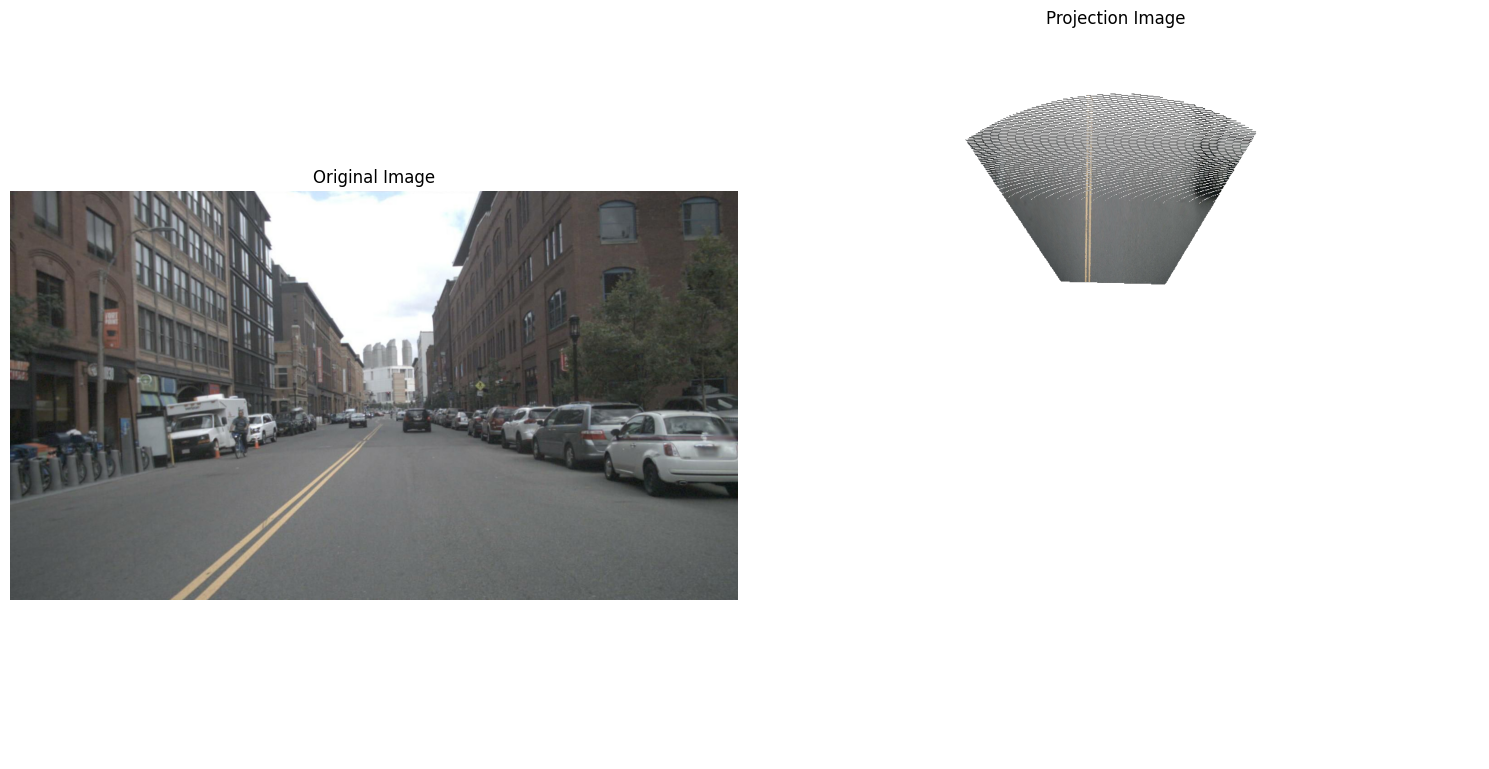

In [5]:
bird_eye_view, img = create_bev_view(sample_token='6402fd1ffaf041d0b9162bd92a7ba0a2', cam_channel='CAM_FRONT', bev_width=40, bev_length=40, resolution=0.04)
visualize_bev_view(bird_eye_view=bird_eye_view, original_img=img, save_flag=False)

### Smoothing
- Use morphological closing operation to remove small holes
- Use Gaussian blur to smooth edges

In [6]:
def smooth_bev_image(image, cam_channel='CAM_FRONT'):
    """
    Apply smoothing operations to the BEV image

    Args:
    - image: BEV image to smooth
    - resolution: resolution in meters/pixel

    Returns:
    - smoothed_image: processed image
    """
    kernel_size = 3
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply morphological closing operation
    if cam_channel == 'CAM_BACK':
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=2)
    else:
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Apply Gaussian blur
    # image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

    return image

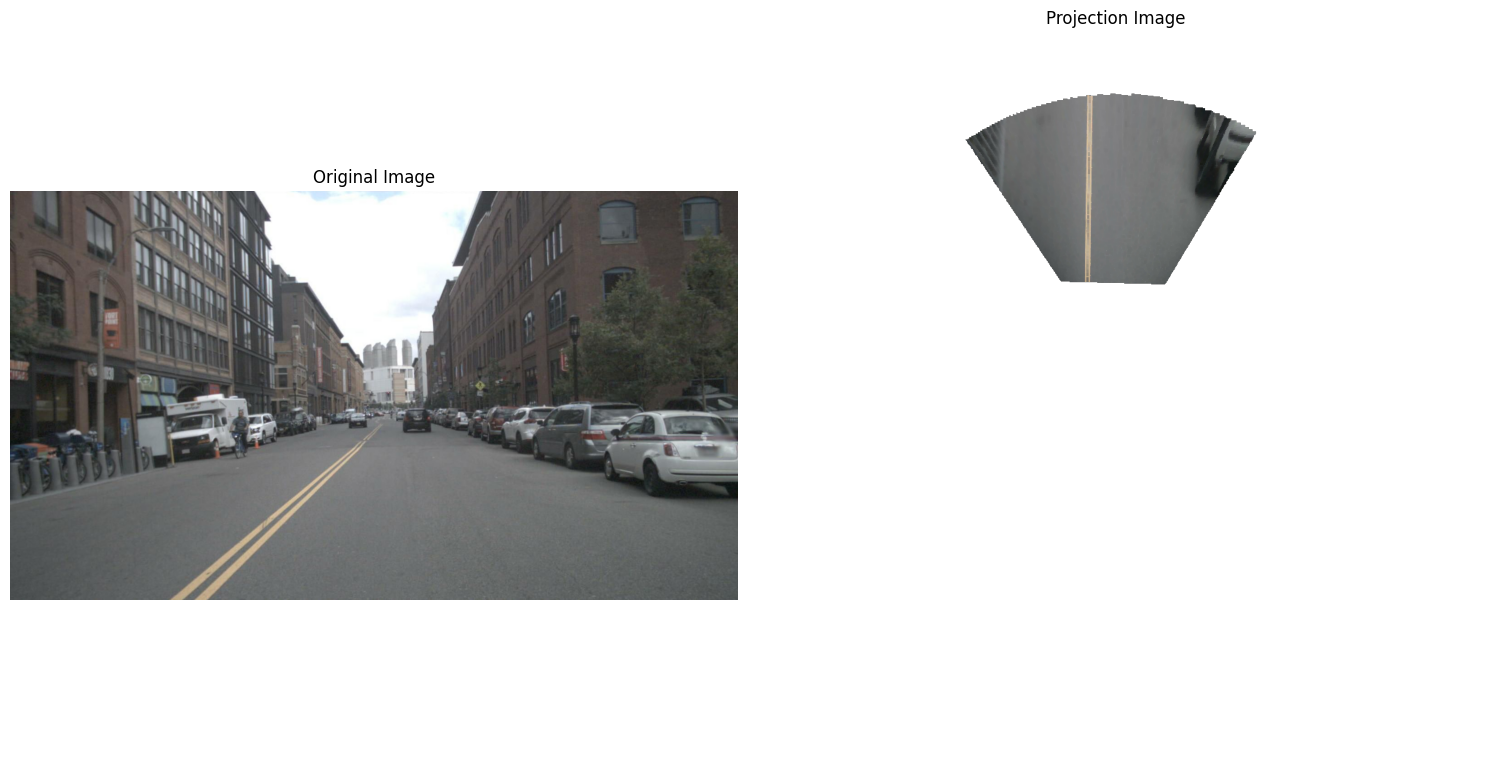

In [7]:
bird_eye_view = smooth_bev_image(bird_eye_view, cam_channel='CAM_FRONT')
visualize_bev_view(bird_eye_view=bird_eye_view, original_img=img, save_flag=False)

## Get the projection images of all six cameras
### Get camera parameters

In [8]:
def get_camera_info(sample_token, cam_channel):
    """
    Get camera position and orientation information in vehicle coordinate system
    
    Args:
    - sample_token: sample token
    - cam_channel: camera channel
    
    Returns:
    - camera_info: dictionary containing camera information
    """
    sample = nusc.get('sample', sample_token)
    cam_token = sample['data'][cam_channel]
    cam_data = nusc.get('sample_data', cam_token)
    cs_record = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    
    # Get camera intrinsic parameters
    intrinsic = np.array(cs_record['camera_intrinsic'])
    
    # Get camera extrinsic parameters
    translation = np.array(cs_record['translation'])
    rotation = Quaternion(cs_record['rotation']).rotation_matrix
    
    # Get ego pose
    ego_pose = nusc.get('ego_pose', cam_data['ego_pose_token'])
    ego_translation = np.array(ego_pose['translation'])
    ego_rotation = Quaternion(ego_pose['rotation']).rotation_matrix
    
    # Return camera information
    camera_info = {
        'translation': translation,
        'rotation': rotation,
        'intrinsic': intrinsic,
        'ego_translation': ego_translation,
        'ego_rotation': ego_rotation
    }
    
    return camera_info

camera_info_test = get_camera_info(sample_token='6402fd1ffaf041d0b9162bd92a7ba0a2', cam_channel='CAM_FRONT')
for key, value in camera_info_test.items():
    print(f'{key}: {value}\n')


translation: [1.72200568 0.00475453 1.49491292]

rotation: [[ 0.01026021  0.00843345  0.9999118 ]
 [-0.99987258  0.01231626  0.01015593]
 [-0.01222952 -0.99988859  0.00855874]]

intrinsic: [[1.25281310e+03 0.00000000e+00 8.26588115e+02]
 [0.00000000e+00 1.25281310e+03 4.69984663e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

ego_translation: [ 667.61135696 1594.30056674    0.        ]

ego_rotation: [[ 0.75567417  0.6545667  -0.02233796]
 [-0.65476628  0.75582808 -0.00224152]
 [ 0.01541644  0.01632     0.99974796]]



### Set function to process one camera's projection image

In [9]:
def process_single_camera(sample_token, cam_channel, bev_width=40, bev_length=40, resolution=0.04):
    """
    Process the BEV projection of a single camera
    
    Args:
    - sample_token: sample token
    - cam_channel: camera channel
    - bev_width: BEV width (meters)
    - bev_length: BEV length (meters)   
    - resolution: resolution (meters/pixel)
    
    Returns:
    - bird_eye_view: processed BEV image 
    - projection_mask: projection mask
    - camera_info: camera information   
    """
    camera_info = get_camera_info(sample_token, cam_channel)
    
    bird_eye_view, _ = create_bev_view(
        sample_token=sample_token, cam_channel=cam_channel, 
        bev_width=bev_width, 
        bev_length=bev_length, 
        resolution=resolution
    )
    bird_eye_view = smooth_bev_image(bird_eye_view, cam_channel=cam_channel)
    
    # Create projection mask (Alpha > 0 area)
    projection_mask = (bird_eye_view[:, :, 3] > 0).astype(np.uint8)
    
    return bird_eye_view, projection_mask, camera_info

process_single_camera(sample_token='6402fd1ffaf041d0b9162bd92a7ba0a2', cam_channel='CAM_FRONT')


Read image: F:/Project/nuscenes-devkit/v1.0-mini\samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151618912404.jpg
Image size: 1600 x 900
Top view size: 1000 x 1000

Successfully mapped pixels: 285538


(array([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [

### Set multiple threads to process all cameras at the same time
- Create 6 threads to process 6 cameras at the same time
- Use thread pool to parallelly process

In [12]:
def process_camera_worker(params):
    """
    Create a new thread to process the BEV projection of a single camera
    
    Args:
    - params: dictionary containing processing parameters
    
    Returns:
    - camera channel
    - processing result (bev, mask, camera_info)
    """
    sample_token = params['sample_token']
    cam_channel = params['cam_channel']
    bev_width = params['bev_width']
    bev_length = params['bev_length']
    resolution = params['resolution']
    
    print(f"\nThread starts processing camera: {cam_channel}")
    
    bev, mask, camera_info = process_single_camera(
        sample_token, cam_channel, bev_width, bev_length, resolution
    )
    print(f"Camera {cam_channel} processed")
    return {
        'cam_channel': cam_channel,
        'bev': bev,
        'mask': mask,
        'camera_info': camera_info
    }

def process_all_cameras_parallel(sample_token, bev_width=40, bev_length=40, resolution=0.04, max_workers=6):
    """
    Parallelly process the BEV projection of all cameras
    
    Args:
    - sample_token: sample token
    - bev_width: BEV width (meters)
    - bev_length: BEV length (meters)
    - resolution: resolution (meters/pixel)
    - max_workers: maximum number of threads
    
    Returns:
    - bev_results: dictionary containing all camera BEV results
    """
    bev_results = {}
    
    # Prepare thread task parameters
    tasks = []
    for cam_channel in camera_channels:
        params = {
            'sample_token': sample_token,
            'cam_channel': cam_channel,
            'bev_width': bev_width,
            'bev_length': bev_length,
            'resolution': resolution
        }
        tasks.append(params)
    
    # Use thread pool to parallelly process
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        futures = [executor.submit(process_camera_worker, params) for params in tasks]
        
        # Collect results
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            cam_channel = result['cam_channel']
            bev_results[cam_channel] = {
                'bev': result['bev'],
                'mask': result['mask'],
                'camera_info': result['camera_info']
            }
    
    print(f"Successfully processed {len(bev_results)}/{len(camera_channels)} cameras")
    
    return bev_results

bev_results_test = process_all_cameras_parallel(sample_token='6402fd1ffaf041d0b9162bd92a7ba0a2')


Thread starts processing camera: CAM_FRONT
Read image: F:/Project/nuscenes-devkit/v1.0-mini\samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151618912404.jpg

Thread starts processing camera: CAM_FRONT_LEFT
Read image: F:/Project/nuscenes-devkit/v1.0-mini\samples/CAM_FRONT_LEFT/n008-2018-08-01-15-16-36-0400__CAM_FRONT_LEFT__1533151618904799.jpg

Thread starts processing camera: CAM_FRONT_RIGHT
Read image: F:/Project/nuscenes-devkit/v1.0-mini\samples/CAM_FRONT_RIGHT/n008-2018-08-01-15-16-36-0400__CAM_FRONT_RIGHT__1533151618920482.jpg

Thread starts processing camera: CAM_BACK
Read image: F:/Project/nuscenes-devkit/v1.0-mini\samples/CAM_BACK/n008-2018-08-01-15-16-36-0400__CAM_BACK__1533151618937558.jpg

Thread starts processing camera: CAM_BACK_LEFT
Read image: F:/Project/nuscenes-devkit/v1.0-mini\samples/CAM_BACK_LEFT/n008-2018-08-01-15-16-36-0400__CAM_BACK_LEFT__1533151618947405.jpg

Thread starts processing camera: CAM_BACK_RIGHT
Read image: F:/Project/nuscenes-devkit/

### Create colorful BEV mask to show the camera coverage
- Set each camera color
- Create mask for each camera
- Assemble all cameras' masks


(-0.5, 999.5, 999.5, -0.5)

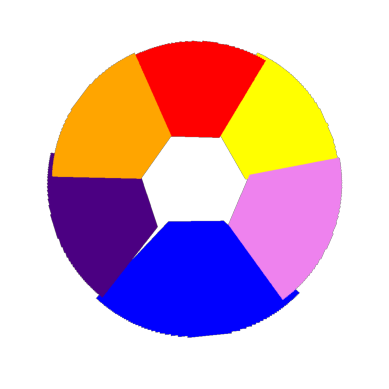

In [13]:
def create_colored_bev_visualization(bev_results):
    """
    Create colorful BEV mask to show the camera coverage
    
    Args:
    - bev_results: dictionary containing all camera BEV results
    
    Returns:
    - colored_bev: colored BEV image
    """
    # Set each camera color
    camera_colors = {
        'CAM_FRONT': [255, 0, 0],          # Red
        'CAM_FRONT_LEFT': [255, 165, 0],   # Orange
        'CAM_FRONT_RIGHT': [255, 255, 0],  # Yellow
        'CAM_BACK': [0, 0, 255],           # Blue
        'CAM_BACK_LEFT': [75, 0, 130],     # Indigo
        'CAM_BACK_RIGHT': [238, 130, 238]  # Purple
    }
    
    bev_height, bev_width = bev_results[list(bev_results.keys())[0]]['bev'].shape[:2]
    colored_bev = np.zeros((bev_height, bev_width, 4), dtype=np.uint8)
    
    # Create mask for each camera
    for cam_channel, result in bev_results.items():
        mask = result['bev'][:, :, 3] > 0
            
        if cam_channel in camera_colors:
            color = np.array(camera_colors[cam_channel], dtype=np.uint8)
            for c in range(3):
                colored_bev[:, :, c][mask] = color[c]
            
            # Set Alpha channel to 255
            colored_bev[:, :, 3][mask] = 255
    
    return colored_bev

colored_bev_test = create_colored_bev_visualization(bev_results=bev_results_test)
plt.imshow(colored_bev_test)
plt.axis('off')

### Stitch all cameras' projection images to build a complete BEV image
- Calculate the contribution of each camera
- Merge all cameras' projection images based on the contribution

In [15]:
def position_based_stitch_bev_images(bev_results):
    """
    Assemble multiple BEV images based on camera position information
    
    Args:
    - bev_results: dictionary containing all camera BEV results
    - resolution: resolution (meters/pixel)
    
    Returns:
    - stitched_bev: stitched BEV image
    """
    
    # Initialize variables
    bev_height, bev_width_pixels = bev_results[list(bev_results.keys())[0]]['bev'].shape[:2]
    stitched_bev = np.zeros((bev_height, bev_width_pixels, 4), dtype=np.uint8)
    camera_contributions = np.zeros((bev_height, bev_width_pixels, len(bev_results), 4), dtype=np.float32)
    camera_weights = np.zeros((bev_height, bev_width_pixels, len(bev_results)), dtype=np.float32)
    camera_positions = {}
    
    # Priority order: front camera > back camera > side front camera > side back camera
    camera_priority = {
        'CAM_FRONT': 1,
        'CAM_FRONT_LEFT': 3,
        'CAM_FRONT_RIGHT': 3,
        'CAM_BACK': 2,
        'CAM_BACK_LEFT': 4,
        'CAM_BACK_RIGHT': 4
    }
    
    # Collect contributions from each camera
    for i, (cam_channel, result) in enumerate(bev_results.items()):
        # Extract camera information and BEV image
        bev = result['bev'].astype(np.float32)
        camera_info = result['camera_info']
        translation = camera_info['translation']
        # Position of the camera in the ego coordinate system
        camera_positions[cam_channel] = translation
        
        # Collect valid pixels
        valid_pixels = bev[:, :, 3] > 0    
        if not np.any(valid_pixels):
            continue
            
        base_priority = camera_priority.get(cam_channel)
        
        # Collect coordinates of valid pixels
        y_indices, x_indices = np.where(valid_pixels)
        
        # Valid pixels
        mask = np.zeros((bev_height, bev_width_pixels), dtype=np.uint8)
        mask[y_indices, x_indices] = 1
        
        # Distance from each pixel to the edge
        dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
        # Normalize
        max_dist = np.max(dist_transform) if np.max(dist_transform) > 0 else 1.0
        dist_transform = dist_transform / max_dist
        
        # Calculate contribution for each pixel
        for j in range(len(y_indices)):
            y, x = y_indices[j], x_indices[j]
            
            # Calculate weight
            edge_weight = dist_transform[y, x]
            pixel_weight = base_priority * (1.0 - 0.3 * edge_weight)
            pixel_weight = 1 / pixel_weight
            
            # Store contribution and weight
            camera_contributions[y, x, i, :] = bev[y, x, :]
            camera_weights[y, x, i] = pixel_weight
    
    # Merge contributions from all cameras
    for y in range(bev_height):
        for x in range(bev_width_pixels):
            pixel_weights = camera_weights[y, x, :]
            
            if np.sum(pixel_weights) == 0:
                continue
            # If only one camera has contribution then use it
            non_zero_indices = np.nonzero(pixel_weights)[0]
            if len(non_zero_indices) == 1:
                i = non_zero_indices[0]
                stitched_bev[y, x, :] = camera_contributions[y, x, i, :].astype(np.uint8)
                continue
            
            pixel_weights = pixel_weights / np.sum(pixel_weights)
            # Merge contributions
            blended_pixel = np.zeros(4, dtype=np.float32)
            for i in range(len(bev_results)):
                if pixel_weights[i] > 0:
                    blended_pixel += pixel_weights[i] * camera_contributions[y, x, i, :]
            if blended_pixel[3] > 0:
                stitched_bev[y, x, :] = blended_pixel.astype(np.uint8)
            else:
                stitched_bev[y, x, :] = blended_pixel.astype(np.uint8)
    
    print("\nCamera positions in the ego coordinate system:")
    for cam, pos in camera_positions.items():
        print(f"{cam}: {pos}")
    
    return stitched_bev

### Visualize
- Plot each camera's BEV
- Plot the vehicle position
- Plot the camera position
- Plot the stitched BEV(include camera positions and vehicle position)
- Plot the colorful BEV mask


In [27]:
def visualize_multicam_bev(sample_token, bev_results, stitched_bev=None, save_flag=False):
    """
    Visualize multicamera BEV results
    
    Args:
    - sample_token: sample token
    - bev_results: dictionary containing all camera BEV results
    - stitched_bev: stitched BEV image (optional)
    - save_flag: whether to save image
    """
    # Get the number of rows and columns for the plot
    n_cols = 3
    n_rows = 4  # For the stitched BEV and the colored visualization
    plt.figure(figsize=(n_cols * 5, n_rows * 5))
    
    # Plot each camera's BEV
    for i, (cam_channel, result) in enumerate(bev_results.items()):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.title(f'BEV: {cam_channel}')
        bev_img = result['bev']
        plt.imshow(bev_img)
        plt.axis('off')
        
        # Get the center coordinates of the image (representing the vehicle position)
        bev_height, bev_width_pixels = bev_img.shape[:2]
        center_x = bev_width_pixels // 2
        center_y = bev_height // 2
        
        # Plot the vehicle position
        plt.plot(center_x, center_y, 'o', color='red', markersize=3)
        
        # Plot the camera position
        translation = result['camera_info']['translation']
        cam_x = translation[0]
        cam_y = translation[1]
        # Calculate the camera position in the image (relative to the center point) - adapted to horizontal mirroring
        cam_pixel_x = center_x - int(cam_y / 0.04)  # Y-axis corresponds to the horizontal axis, and the negative sign becomes a subtraction
        cam_pixel_y = center_y - int(cam_x / 0.04)  # X-axis corresponds to the vertical axis (positive upwards)
        if 0 <= cam_pixel_y < bev_height and 0 <= cam_pixel_x < bev_width_pixels:
            plt.plot(cam_pixel_x, cam_pixel_y, 'o', color='blue', markersize=3)
    
    if stitched_bev is not None:
        plt.subplot(n_rows, n_cols, 7)
        plt.title('Stitched BEV (All Cameras)')
        plt.imshow(stitched_bev)
        plt.axis('off')
        
        # Plot the camera position
        for cam_channel, result in bev_results.items():
            translation = result['camera_info']['translation']
            cam_x = translation[0]
            cam_y = translation[1]
            cam_pixel_x = center_x - int(cam_y / 0.04)  # Y-axis corresponds to the horizontal axis, and the negative sign becomes a subtraction
            cam_pixel_y = center_y - int(cam_x / 0.04)  # X-axis corresponds to the vertical axis (positive upwards)
                
            plt.plot(cam_pixel_x, cam_pixel_y, 'o', color='blue', markersize=3)
        
        # Plot the vehicle center position
        bev_height, bev_width_pixels = stitched_bev.shape[:2]
        center_x = bev_width_pixels // 2
        center_y = bev_height // 2
        plt.plot(center_x, center_y, 'o', color='red', markersize=3)
    
    # Plot the visualization
    colored_viz = create_colored_bev_visualization(bev_results)
    plt.subplot(n_rows, n_cols, 8)
    plt.title('Camera Coverage Visualization')
    plt.imshow(colored_viz)
    plt.axis('off')
    
    plt.tight_layout()
    if save_flag:
        plt.savefig(f'multicam_bev_stitched_{sample_token[:8]}.png', transparent=True)
    plt.show()
    
    # Show the BEV individually
    if stitched_bev is not None:
        plt.figure(figsize=(10, 10))
        plt.title('Stitched Bird\'s Eye View (All Cameras)')
        plt.imshow(stitched_bev)
        plt.axis('off')
        
        # Plot all camera positions
        for cam_channel, result in bev_results.items():
            translation = result['camera_info']['translation']
            cam_x = translation[0]
            cam_y = translation[1]
            cam_pixel_x = center_x - int(cam_y / 0.04)
            cam_pixel_y = center_y - int(cam_x / 0.04)
                
            plt.plot(cam_pixel_x, cam_pixel_y, 'o', color='blue', markersize=3)
        
        # Plot the vehicle center position
        bev_height, bev_width_pixels = stitched_bev.shape[:2]
        center_x = bev_width_pixels // 2
        center_y = bev_height // 2
        plt.plot(center_x, center_y, 'o', color='red', markersize=3)
        
        if save_flag:
            plt.savefig(f'stitched_bev_{sample_token[:8]}.png', transparent=True)
        plt.show()


Thread starts processing camera: CAM_FRONT
Read image: F:/Project/nuscenes-devkit/v1.0-mini\samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151609012404.jpg

Thread starts processing camera: CAM_FRONT_LEFT
Read image: F:/Project/nuscenes-devkit/v1.0-mini\samples/CAM_FRONT_LEFT/n008-2018-08-01-15-16-36-0400__CAM_FRONT_LEFT__1533151609004799.jpg

Thread starts processing camera: CAM_FRONT_RIGHT
Read image: F:/Project/nuscenes-devkit/v1.0-mini\samples/CAM_FRONT_RIGHT/n008-2018-08-01-15-16-36-0400__CAM_FRONT_RIGHT__1533151609020482.jpg

Thread starts processing camera: CAM_BACK
Read image: F:/Project/nuscenes-devkit/v1.0-mini\samples/CAM_BACK/n008-2018-08-01-15-16-36-0400__CAM_BACK__1533151609037558.jpg

Thread starts processing camera: CAM_BACK_LEFT
Read image: F:/Project/nuscenes-devkit/v1.0-mini\samples/CAM_BACK_LEFT/n008-2018-08-01-15-16-36-0400__CAM_BACK_LEFT__1533151609047405.jpg

Thread starts processing camera: CAM_BACK_RIGHT
Read image: F:/Project/nuscenes-devkit/

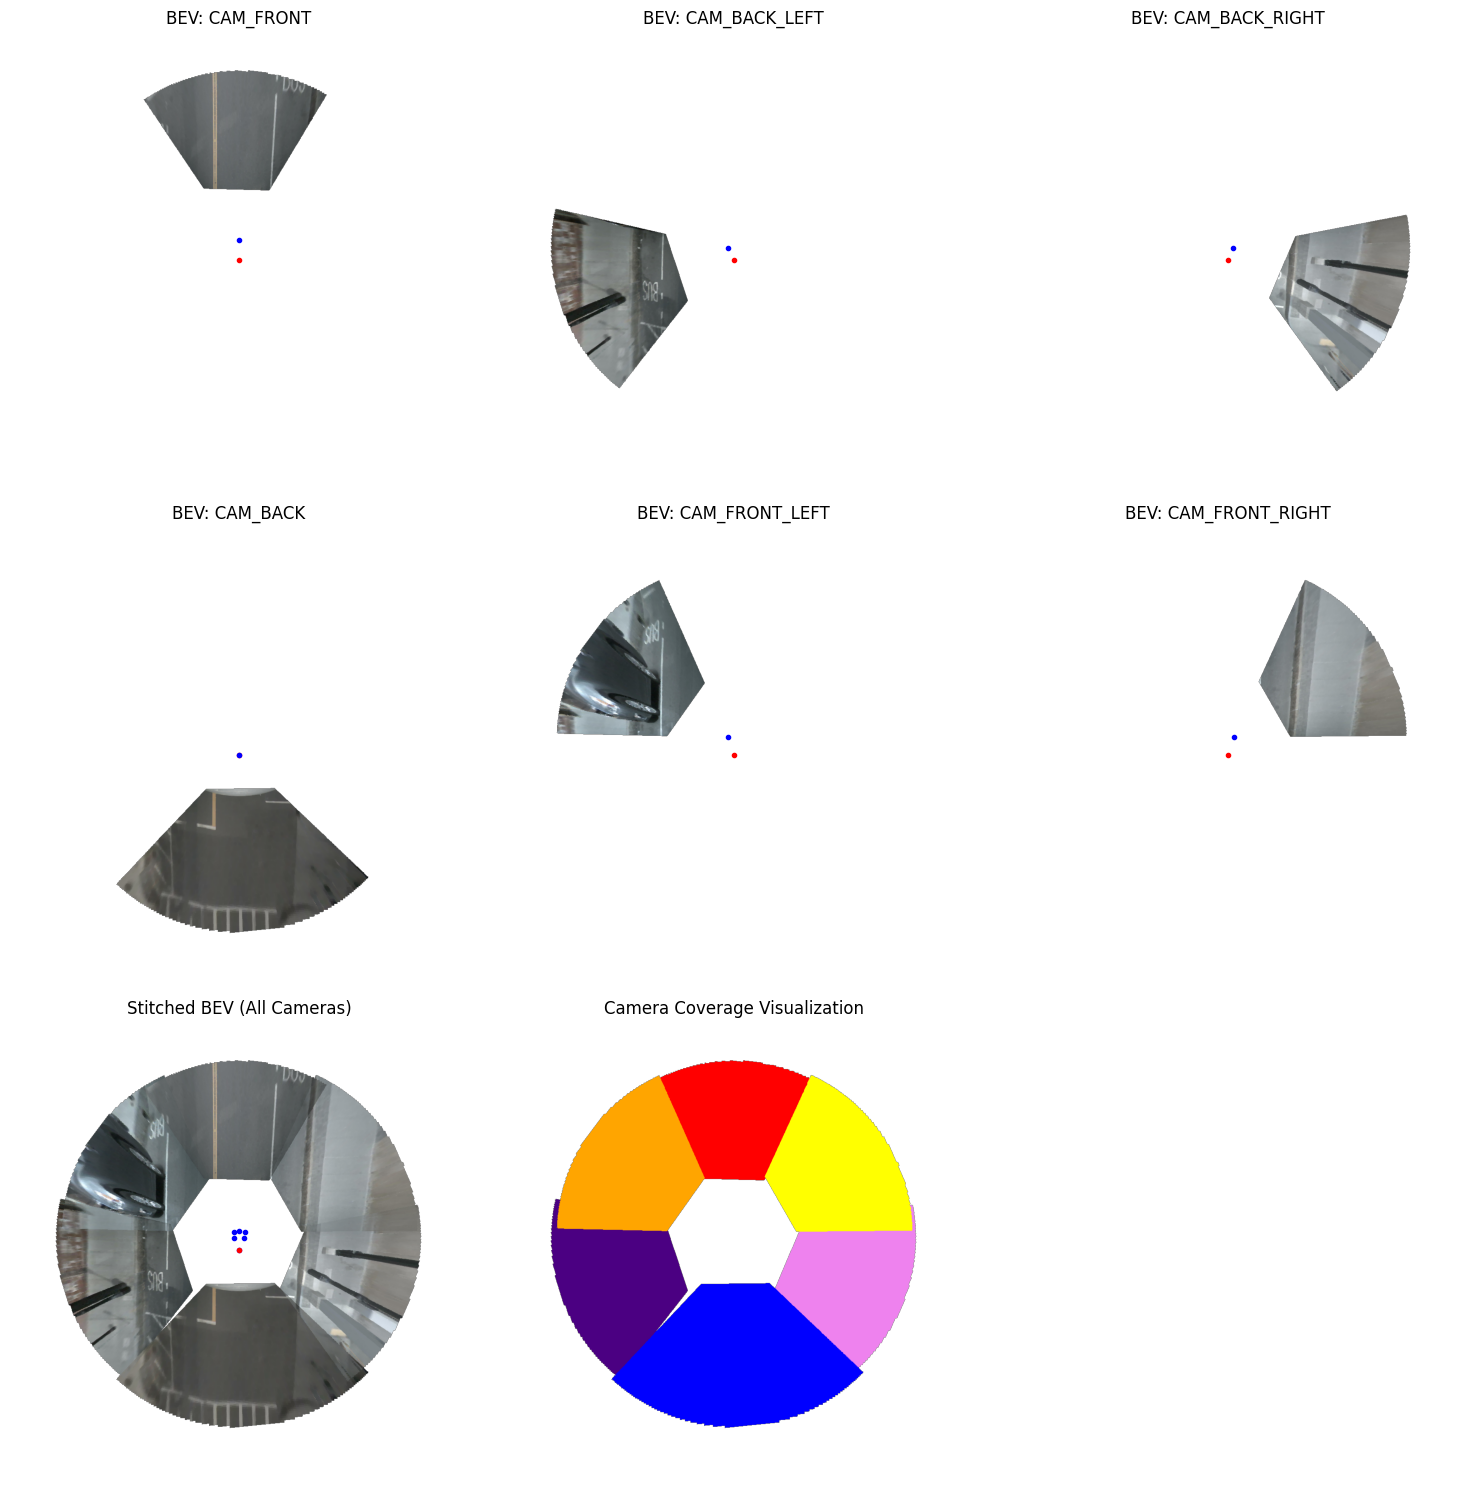

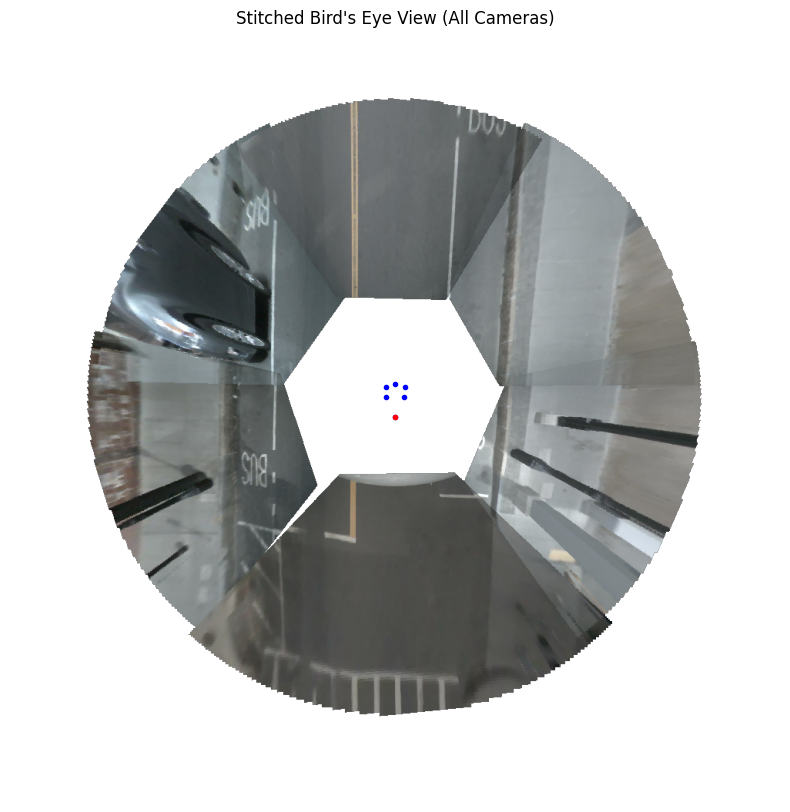

In [28]:
my_sample = nusc.sample[50]

bev_results = process_all_cameras_parallel(sample_token=my_sample['token'], bev_width=40, bev_length=40, resolution=0.04)
stitched_bev = position_based_stitch_bev_images(bev_results)
visualize_multicam_bev(sample_token=my_sample['token'], bev_results=bev_results, stitched_bev=stitched_bev, save_flag=False)

# Optimize the BEV stitching process
